# Notebook de apoyo (exploración interactiva)

Este cuaderno complementa el informe en LaTeX.

**Objetivos:**
- Verificar resultados teóricos básicos: $f(0,0)$, $\nabla f(0,0)$, $\nabla^2 f(0,0)$.
- Visualizar contornos y trayectorias de los algoritmos.
- Realizar un pequeño barrido de parámetros (alpha) para el descenso por gradiente.
- Exportar figuras y una tabla corta a `results/` para mantener consistencia con el repo.


In [9]:
# Bootstrap de ruta del repo y parámetros globales
import sys, math
from pathlib import Path
ROOT = Path.cwd()
for _ in [0,1,2]:
    if (ROOT / 'src').exists():
        break
    ROOT = ROOT.parent
sys.path.insert(0, str(ROOT))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.model import f_xy, grad_xy, hess_xy
from src.methods import gradient_descent, newton_regularizado

# Reproducibilidad y parámetros
SEED = 42
np.random.seed(SEED)
TOL = 1e-10
MAXIT_GD = 10_000
MAXIT_NT = 500

DIR_FIG = ROOT / 'results' / 'figuras'; DIR_FIG.mkdir(parents=True, exist_ok=True)
DIR_TAB = ROOT / 'results' / 'tablas';  DIR_TAB.mkdir(parents=True, exist_ok=True)
print('ROOT:', ROOT)


ROOT: /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project


In [10]:
# Chequeo teórico: valor en el óptimo, norma del gradiente, autovalores de la Hessiana
f00 = f_xy(0.0,0.0)
g00 = grad_xy(0.0,0.0)
H00 = hess_xy(0.0,0.0)
evals = np.linalg.eigvals(H00)
print('f(0,0)      =', f00, '   (esperado ~ -2*tan(1))')
print('||grad(0,0)||=', np.linalg.norm(g00))
print('H(0,0) =\n', H00)
print('H(0,0) eigenvalues =', evals)


f(0,0)      = -3.1148154493098046    (esperado ~ -2*tan(1))
||grad(0,0)||= 0.0
H(0,0) =
 [[13.70207528  0.        ]
 [ 0.         13.70207528]]
H(0,0) eigenvalues = [13.70207528 13.70207528]


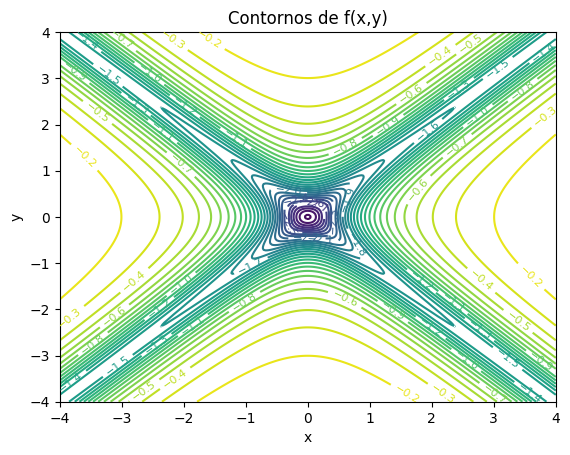

In [11]:
# Malla y contornos base
def grid_values(xmin=-4, xmax=4, ymin=-4, ymax=4, n=300):
    xs = np.linspace(xmin, xmax, n)
    ys = np.linspace(ymin, ymax, n)
    XX, YY = np.meshgrid(xs, ys)
    fvec = np.vectorize(f_xy)
    ZZ = fvec(XX, YY)
    return XX, YY, ZZ

XX, YY, ZZ = grid_values()
plt.figure()
cs = plt.contour(XX, YY, ZZ, levels=30)
plt.clabel(cs, inline=True, fontsize=8)
plt.title('Contornos de f(x,y)')
plt.xlabel('x'); plt.ylabel('y')
plt.show()


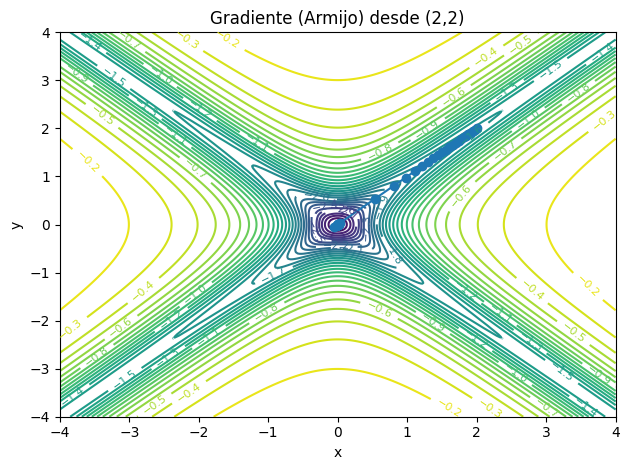

Guardado: /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project/results/figuras/nb_contorno_gd_armijo.png


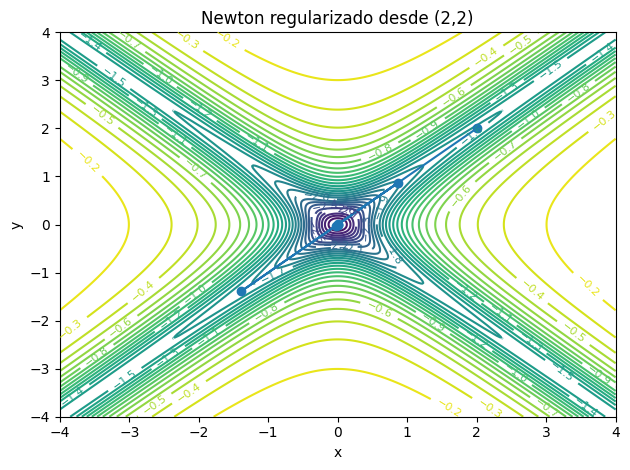

Guardado: /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project/results/figuras/nb_contorno_newton.png


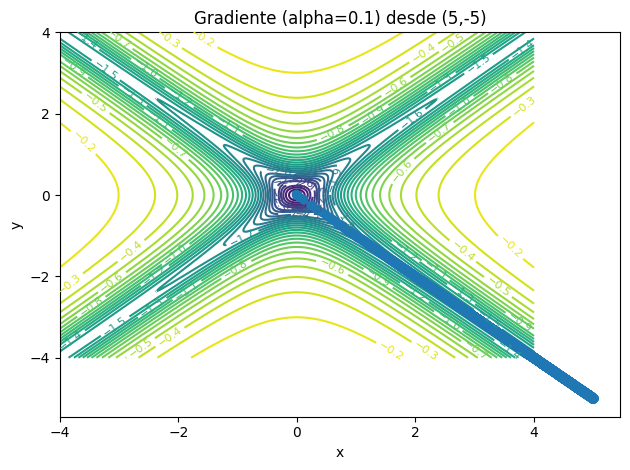

Guardado: /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project/results/figuras/nb_contorno_gd_fijo.png


In [12]:
# Función auxiliar para graficar trayectorias sobre contornos y exportar
def plot_path(path, title, fname):
    P = np.asarray(path)
    plt.figure()
    cs = plt.contour(XX, YY, ZZ, levels=30)
    plt.clabel(cs, inline=True, fontsize=8)
    plt.plot(P[:,0], P[:,1], marker='o', linewidth=1.5)
    plt.title(title); plt.xlabel('x'); plt.ylabel('y')
    plt.tight_layout()
    out = DIR_FIG / fname
    plt.savefig(out, dpi=150)
    plt.show()
    print('Guardado:', out)

# Gradiente (Armijo)
r_gd_arm = gradient_descent(2, 2, step='armijo')
plot_path(r_gd_arm['path'], 'Gradiente (Armijo) desde (2,2)', 'nb_contorno_gd_armijo.png')

# Newton regularizado
r_nt = newton_regularizado(2, 2)
plot_path(r_nt['path'], 'Newton regularizado desde (2,2)', 'nb_contorno_newton.png')

# Gradiente paso fijo
r_gd_fix = gradient_descent(5, -5, step='constant', alpha=0.1)
plot_path(r_gd_fix['path'], 'Gradiente (alpha=0.1) desde (5,-5)', 'nb_contorno_gd_fijo.png')


In [13]:
# Mini tabla de resultados y export de .csv y .tex (sin Unicode en encabezados)
starts = [(2.0,2.0), (-2.0,3.0), (5.0,-5.0), (0.5,-1.0), (10.0,0.0)]
rows = []
for (x0,y0) in starts:
    rows.append(gradient_descent(x0,y0, step='armijo'))
    rows.append(gradient_descent(x0,y0, step='constant', alpha=0.1))
    rows.append(newton_regularizado(x0,y0))

flat = []
for r, (x0,y0) in zip(rows, [s for s in starts for _ in range(3)]):
    flat.append({
        'Inicio x0': x0, 'Inicio y0': y0, 'Metodo': r['method'],
        'x*': r['x'], 'y*': r['y'], 'f(x*)': r['f'], 'Iteraciones': r['iters']
    })
df_small = pd.DataFrame(flat)
display(df_small)

csv = DIR_TAB / 'tabla_resultados_peq_nb.csv'
tex = DIR_TAB / 'tabla_resultados_peq_nb.tex'
df_small.to_csv(csv, index=False)
with open(tex, 'w', encoding='utf-8') as fh:
    fh.write(df_small.to_latex(index=False, float_format='%.6g'))
print('Exportados:', csv, 'y', tex)


,Inicio x0,Inicio y0,Metodo,x*,y*,f(x*),Iteraciones
0,2.0,2.0,Gradiente (Armijo),-1.807842e-09,-1.807842e-09,-3.114815,10000
1,2.0,2.0,Gradiente (α=0.1),1.316084e-11,1.316084e-11,-3.114815,225
2,2.0,2.0,"Newton (regularizado, Armijo)",1.075335e-22,1.091878e-22,-3.114815,6
3,-2.0,3.0,Gradiente (Armijo),-1.665697e-09,7.325007e-09,-3.114815,10000
4,-2.0,3.0,Gradiente (α=0.1),1.738785e-11,-1.738785e-11,-3.114815,477
5,-2.0,3.0,"Newton (regularizado, Armijo)",7.404902e+03,-7.404902e+03,-1.557408,4
6,5.0,-5.0,Gradiente (Armijo),-3.314114e-09,3.314114e-09,-3.114815,10000
7,5.0,-5.0,Gradiente (α=0.1),1.133368e-11,-1.133368e-11,-3.114815,6526
8,5.0,-5.0,"Newton (regularizado, Armijo)",-1.264303e-18,1.264303e-18,-3.114815,7
9,0.5,-1.0,Gradiente (Armijo),-3.112170e-09,2.903649e-09,-3.114815,10000


Exportados: /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project/results/tablas/tabla_resultados_peq_nb.csv y /home/hughes_card/Documentos/Escuela/Optimizacion/Proyecto Optimizacion/Optimization-Project/results/tablas/tabla_resultados_peq_nb.tex


In [14]:
# Barrido rápido de alpha (opcional)
alphas = [0.05, 0.1, 0.2, 0.5]
x0,y0 = 10.0, 0.0
rows = []
for a in alphas:
    r = gradient_descent(x0,y0, step='constant', alpha=a)
    rows.append({'alpha':a, 'iters':r['iters'], 'f(x*)':r['f']})
df_alpha = pd.DataFrame(rows)
display(df_alpha)


,alpha,iters,f(x*)
0,0.05,10000,-0.041642
1,0.10,6526,-3.114815
2,0.20,10000,-2.719694
3,0.50,10000,-1.010816
